<a href="https://colab.research.google.com/github/Billyjr2003/deep-learning/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
transform_train = transforms.Compose([
    transforms.RandomApply([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),], p=0.5),
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),

])

In [3]:
train_data = torchvision.datasets.CIFAR10(root="data",
    train=True,
    download=True,
    transform=transform_train ,
    target_transform=None)
test_data = torchvision.datasets.CIFAR10(root="data",
    train=False,
    download=True,
    transform=transform_test ,
    target_transform=None)

100%|██████████| 170498071/170498071 [00:13<00:00, 12403758.60it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
train_data.class_to_idx, train_data.classes

({'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9},
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [5]:
from torch.utils.data import DataLoader
BATCH_SIZE = 128

train_data_loader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,)
test_data_loader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,)



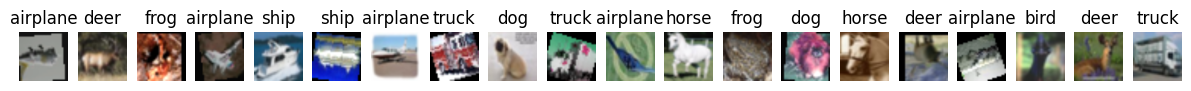

In [7]:
import matplotlib.pyplot as plt
def plot_random_images(data_loader, labels_name, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        # Get a random batch from the DataLoader
        batch = next(iter(data_loader))
        images, labels = batch

        index = torch.randint(0, images.size(0), (1,)).item()
        image = images[index].squeeze().permute(1,2,0).numpy()
        label = labels[index].item()



        axes[i].imshow(image)
        axes[i].set_title(f"{labels_name[label]}")
        axes[i].axis('off')

    plt.show()

plot_random_images(train_data_loader, train_data.classes, 20)


In [8]:
import numpy as np
import cv2
def build_full_grid(imgs, grid, n_skip_row, n_skip_col, n_rows, n_cols, img_shape):
    for row in range(n_rows):
        # iterate through the columns
        for col in range(n_cols):
            # get the image index
            img_idx = row * n_cols + col + n_skip_row * row + n_skip_col * col
            img = imgs[img_idx]
            img = cv2.resize(img, (img_shape[1], img_shape[0]))
            # add the image to the grid
            grid[row * img_shape[0]:(row + 1) * img_shape[0], col * img_shape[1]:(col + 1) * img_shape[1], :] = img
    # return the grid
    return grid
def build_grid(data_loader, grid_size=(9,9)):
    '''Given a data loader build a grid of images to visualize the dataset passed to the model'''
    # get the list of images
    grid_h, grid_w = grid_size
    print("Grid size: ", grid_h * grid_w)
    imgs = []
    i = 0
    for (batch, label) in data_loader:
        for img in batch:
            img_add = img.permute(1,2,0).numpy()
            # img_add =  img_add * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_add = img_add * 255
            imgs.append(img_add)
            i += 1
            if i == grid_h * grid_w:
                break
        if i == grid_h * grid_w:
            break
    # get the number of images
    n_images = len(imgs)
    # get the number of rows and columns
    n_rows, n_cols = grid_size
    # get the number of images to be displayed
    n_display_images = n_rows * n_cols
    # get the number of images to be skipped
    n_skip_images = n_images - n_display_images
    # get the number of images to be skipped per row
    n_skip_row = n_skip_images // n_rows
    # get the number of images to be skipped per column
    n_skip_col = n_skip_images % n_rows
    # get the image size
    img = imgs[0]
    # get the image shape
    img_shape = img.shape
    # get the grid size
    grid_size = (img_shape[0] * n_rows, img_shape[1] * n_cols, img_shape[2])
    # create a grid of images
    grid = np.zeros(grid_size, dtype=np.uint8)
    # iterate through the rows
    grid = build_full_grid(imgs, grid, n_skip_row, n_skip_col, n_rows, n_cols, img_shape)
    return grid

Grid size:  81


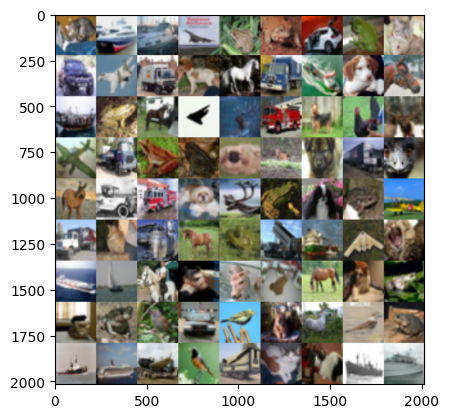

In [10]:
grid =build_grid(test_data_loader)
plt.imshow(grid)
plt.show()

In [11]:
import torch
from torch import nn
from tqdm.auto import tqdm
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):

    model.train()


    train_loss, train_acc = 0, 0





    for batch, (X, y) in tqdm(enumerate(dataloader), desc='training epoch'):


        X, y = X.to(device), y.to(device)


        y_pred = model(X)


        loss = loss_fn(y_pred, y)
        train_loss += loss.item()




        optimizer.zero_grad()


        loss.backward()


        optimizer.step()


        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)





    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):

    model.eval()


    test_loss, test_acc = 0, 0




    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)


            test_pred_logits = model(X)


            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()


            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))




    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          starting_epochs: int,
          epochs: int,
          device: torch.device,
          checkpoint_interval: int):

    print("Training Data Size:", len(train_dataloader.dataset))
    print("Test Data Size:", len(test_dataloader.dataset))

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    highest_train_accuracy = 0.0
    highest_test_accuracy = 0.0
    pbar = tqdm(total=epochs, initial=starting_epochs, dynamic_ncols=True, desc="Training")

    for epoch in range(starting_epochs, epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)


        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        if (epoch + 1) % checkpoint_interval == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'test_loss': test_loss,
                'test_acc': test_acc
            }, f'checkpoint_epoch_last.pth')

        if train_acc > highest_train_accuracy:
          highest_train_accuracy = train_acc


        if test_acc > highest_test_accuracy:
          highest_test_accuracy = test_acc
          torch.save(model, '/content/classifier.pth')
          torch.save(model.state_dict(), "/content/classifier_param.pth")

        pbar.update(1)


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    print(
        f"Highest Train Accuracy: {highest_train_accuracy:.4f} | "
        f"Highest Test Accuracy: {highest_test_accuracy:.4f}"
        )

    return results

In [14]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """


    loss = results['train_loss']
    test_loss = results['test_loss']


    accuracy = results['train_acc']
    test_accuracy = results['test_acc']


    epochs = range(len(results['train_loss']))


    plt.figure(figsize=(15, 7))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [12]:
from torchvision import  models

model = models.resnet50(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = True

num_classes = 10
classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes),  ).to(device)
model.fc = classifier

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 42.0MB/s]


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
NUM_EPOCHS = 15
start_epoch = 0
print(f"Starting from epoch: {start_epoch}")
model_result= train(model=model,
             train_dataloader=train_data_loader,
             test_dataloader=test_data_loader,
             loss_fn=criterion,
             optimizer=optimizer,
             starting_epochs= start_epoch,
             epochs=NUM_EPOCHS,
             device=device,
             checkpoint_interval=5)

Starting from epoch: 0
Training Data Size: 50000
Test Data Size: 10000


Training:   0%|          | 0/15 [00:00<?, ?it/s]

training epoch: 0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.3327 | train_acc: 0.5601 | test_loss: 0.4463 | test_acc: 0.8570


training epoch: 0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.5257 | train_acc: 0.8211 | test_loss: 0.2202 | test_acc: 0.9246


training epoch: 0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.4003 | train_acc: 0.8635 | test_loss: 0.1749 | test_acc: 0.9404


training epoch: 0it [00:00, ?it/s]

Epoch: 4 | train_loss: 0.3397 | train_acc: 0.8864 | test_loss: 0.1631 | test_acc: 0.9439


training epoch: 0it [00:00, ?it/s]

Epoch: 5 | train_loss: 0.2955 | train_acc: 0.9005 | test_loss: 0.1434 | test_acc: 0.9500


training epoch: 0it [00:00, ?it/s]

Epoch: 6 | train_loss: 0.2698 | train_acc: 0.9087 | test_loss: 0.1341 | test_acc: 0.9536


training epoch: 0it [00:00, ?it/s]

Epoch: 7 | train_loss: 0.2428 | train_acc: 0.9177 | test_loss: 0.1361 | test_acc: 0.9539


training epoch: 0it [00:00, ?it/s]

Epoch: 8 | train_loss: 0.2273 | train_acc: 0.9234 | test_loss: 0.1288 | test_acc: 0.9579


training epoch: 0it [00:00, ?it/s]

Epoch: 9 | train_loss: 0.2089 | train_acc: 0.9305 | test_loss: 0.1356 | test_acc: 0.9549


training epoch: 0it [00:00, ?it/s]

Epoch: 10 | train_loss: 0.2003 | train_acc: 0.9341 | test_loss: 0.1326 | test_acc: 0.9558


training epoch: 0it [00:00, ?it/s]

Epoch: 11 | train_loss: 0.1838 | train_acc: 0.9392 | test_loss: 0.1256 | test_acc: 0.9595


training epoch: 0it [00:00, ?it/s]

Epoch: 12 | train_loss: 0.1833 | train_acc: 0.9393 | test_loss: 0.1205 | test_acc: 0.9603


training epoch: 0it [00:00, ?it/s]

Epoch: 13 | train_loss: 0.1698 | train_acc: 0.9435 | test_loss: 0.1250 | test_acc: 0.9607


training epoch: 0it [00:00, ?it/s]

Epoch: 14 | train_loss: 0.1658 | train_acc: 0.9451 | test_loss: 0.1196 | test_acc: 0.9608


training epoch: 0it [00:00, ?it/s]

Epoch: 15 | train_loss: 0.1528 | train_acc: 0.9501 | test_loss: 0.1187 | test_acc: 0.9609
Highest Train Accuracy: 0.9501 | Highest Test Accuracy: 0.9609


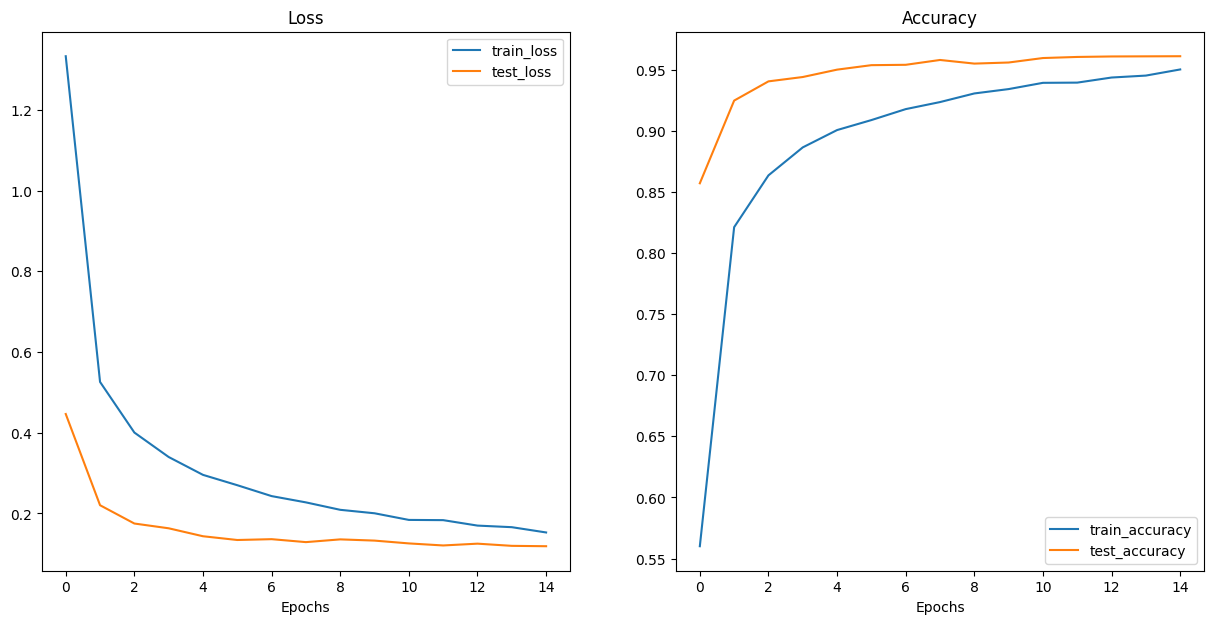

In [16]:
plot_loss_curves(model_result)

In [20]:
from tqdm.auto import tqdm


y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_data_loader, desc="Making predictions"):

    X, y = X.to(device), y.to(device)

    y_logit = model(X)

    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/79 [00:00<?, ?it/s]

In [18]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.3 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [19]:
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19

0.23.1


In [21]:
y_labels = []
for batch, (X, y) in enumerate(test_data_loader):
  y_labels.append(y)

y_labels_tensor = torch.cat(y_labels)



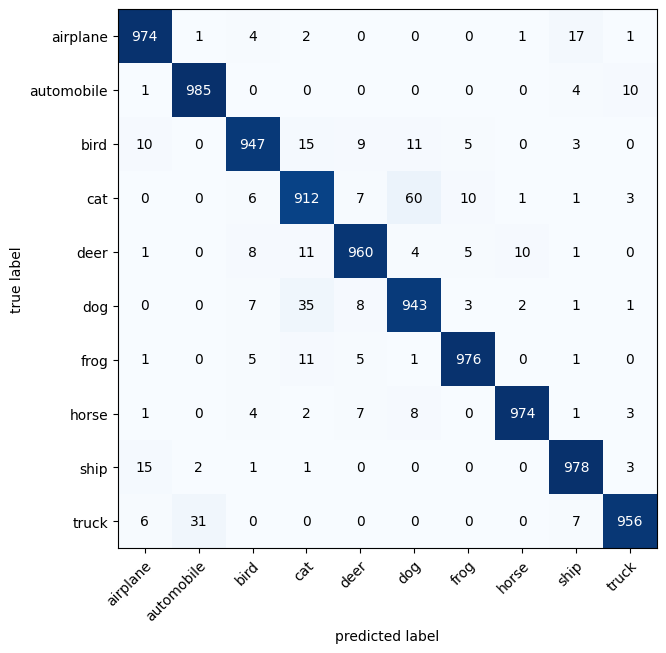

In [22]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


confmat = ConfusionMatrix(num_classes=10, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_labels_tensor)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=train_data.classes,
    figsize=(10, 7)
);

In [23]:
from typing import List, Tuple
def pred_and_plot_image(model: torch.nn.Module,
                        data_loader,
                        class_names: List[str],
                        transform= None,
                        num_images=15,
                        device: torch.device=device):


    model.to(device)


    model.eval()
    with torch.inference_mode():
      for i in range(num_images):
          # Get a random batch from the DataLoader
          batch = next(iter(data_loader))
          images, labels = batch

          index = torch.randint(0, images.size(0), (1,)).item()
          img = images[index].squeeze().permute(1,2,0).numpy()
          image = images[index].unsqueeze(dim=0)
          label = labels[index].item()
          target_image_pred = model(image.to(device))


          target_image_pred_probs = torch.softmax(target_image_pred, dim=1)


          target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1).item()

          plt.figure()
          plt.imshow(img)
          plt.title(f"True_label: {class_names[label]} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
          plt.axis(False);

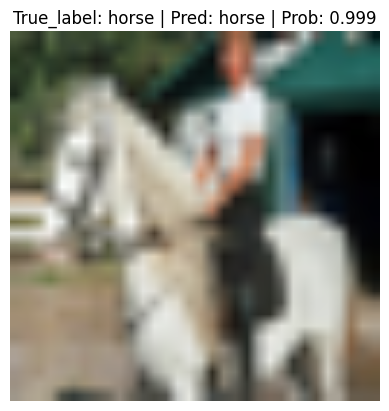

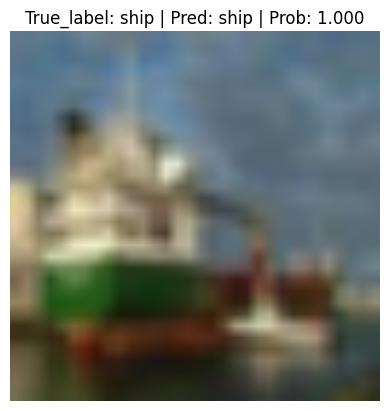

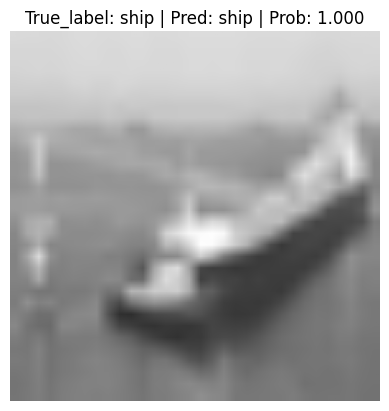

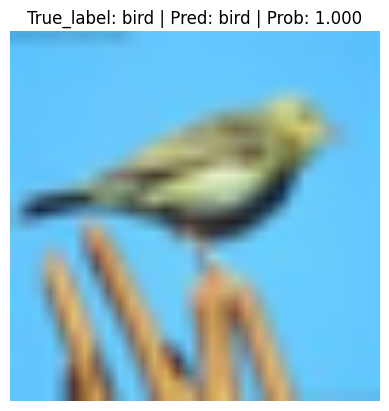

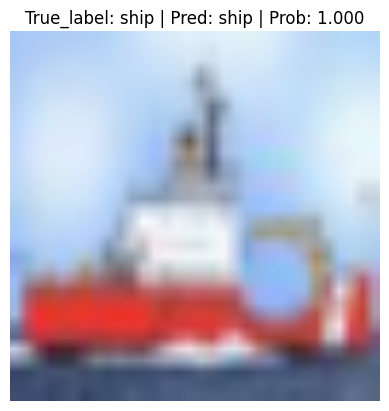

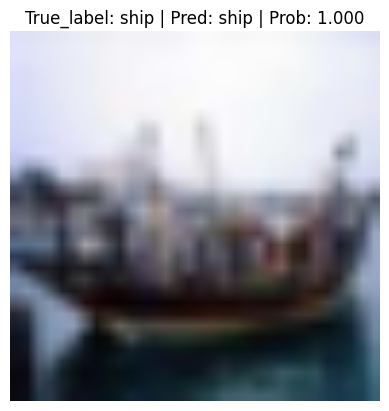

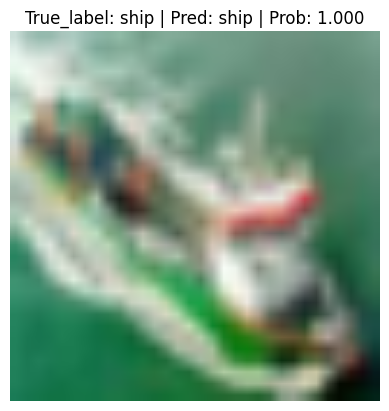

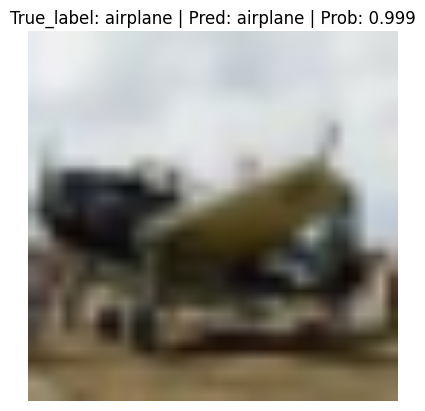

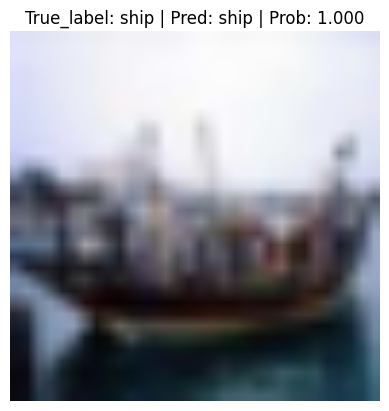

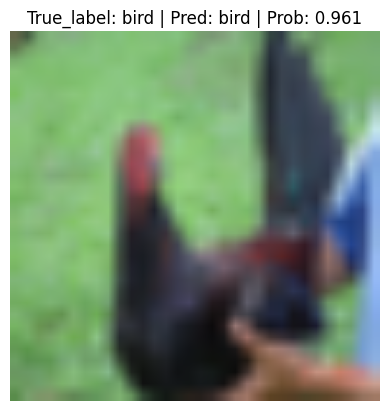

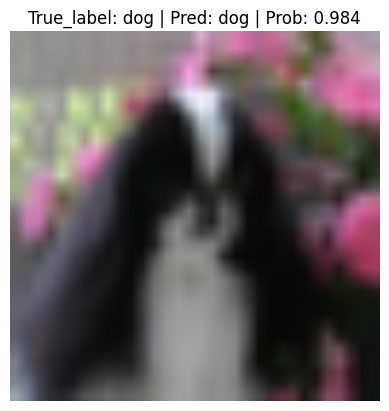

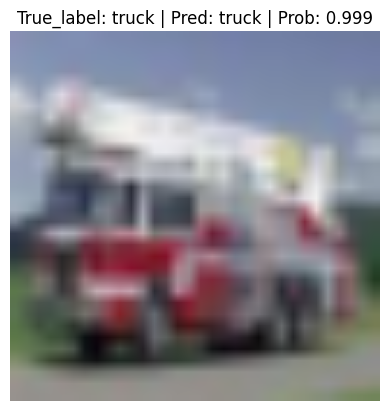

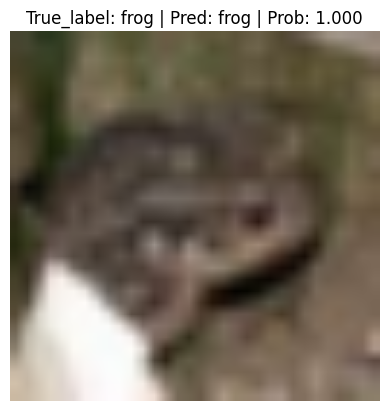

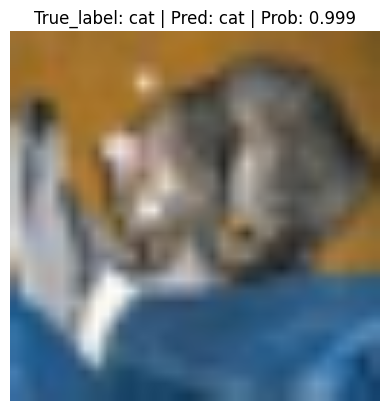

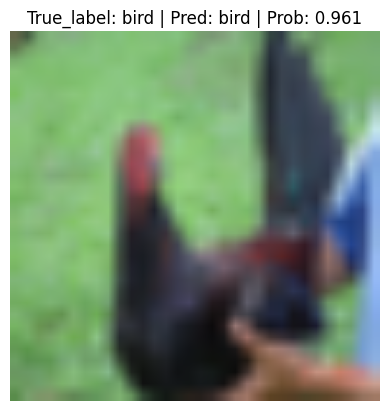

In [24]:
pred_and_plot_image(model=model,
                    data_loader=test_data_loader,
                    class_names=train_data.classes,
                        )